# TP 2 - Procesamiento del Lenguaje Natural

## Librerias

In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score,  recall_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import confusion_matrix, classification_report
from mlxtend.preprocessing import DenseTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.layers import Dense, Input, Dropout
import os

In [2]:
df = pd.read_csv('train.csv', sep=',')
df.head(10)

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo
5,5,Probablemente mi película favorita de todos lo...,positivo
6,6,Seguro que me gustaría ver una resurrección de...,positivo
7,7,"Este espectáculo fue una idea increíble, fresc...",negativo
8,8,Alentados por los comentarios positivos sobre ...,negativo
9,9,"Si te gusta la risa original desgarradora, te ...",positivo


In [3]:
df.shape

(50000, 3)

In [4]:
df_test = pd.read_csv('test.csv', sep=',')
df_test

,ID,review_es
0,60000,La mayor virtud de esta película es su existen...
1,60001,"No soy un experto cinéfilo, pero pocas veces m..."
2,60002,Si no eres un incondicional del humor estilo T...
3,60003,"No sé qué está pasando, si la gente se deja ll..."
4,60004,"Pero cuando amanece,y me quedo solo,siento en ..."
...,...,...
8594,68594,"Buena no, lo siguiente. Por fin un film serio ..."
8595,68595,"Me esperaba mucho, pero que mucho, más.Guión m..."
8596,68596,"De mal cuerpo como sensación al finalizar, de ..."
8597,68597,Los que han añadido comentarios os lo han dich...


In [5]:
def mostrar_scores(y_test: np.ndarray, y_prediccion: np.ndarray):
    accuracy = accuracy_score(y_test,y_prediccion)
    recall = recall_score(y_test,y_prediccion)
    f1 = f1_score(y_test,y_prediccion,)
    precision = precision_score(y_test,y_prediccion)

    print("Accuracy: "+str(accuracy))
    print("Recall: "+str(recall))
    print("Precision: "+str(precision))
    print("f1 score: "+str(f1))

### Preprocesamiento

In [6]:
def cantidad_de_palabras(review):
    return len(review.split())

In [7]:
df_copia = df.copy()
df_copia['cantidad_de_palabras'] = df_copia['review_es'].apply(cantidad_de_palabras)

In [8]:
df_copia['cantidad_de_palabras'].describe()

count    50000.000000
mean       237.233680
std        179.529306
min          6.000000
25%        123.000000
50%        172.000000
75%        293.000000
max       2450.000000
Name: cantidad_de_palabras, dtype: float64

In [9]:
df_copia['review_es'].duplicated().sum()

401

In [10]:
df = df.drop_duplicates(subset=['review_es'])
df.shape

(49599, 3)

In [11]:
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(df['review_es'])

vocabulario = vectorizer.get_feature_names_out()

numero_de_palabras_unicas = len(vocabulario)

print("Numero de palabras unicas en el dataset pre preprocesamiento:", numero_de_palabras_unicas)

Numero de palabras unicas en el dataset pre preprocesamiento: 175853


In [14]:
df_preprocesado = df.copy()
#si ya estan descargados los paquetes no es necesario volver a hacerlo.
#nltk.download('stopwords')
#nltk.download('punkt')

stop_words = set(stopwords.words('spanish'))

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Zñáéíóúü\s]', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    stemmer = nltk.stem.SnowballStemmer('spanish')
    stems = [stemmer.stem(token) for token in tokens]
    preprocessed_text = ' '.join(stems)
    return preprocessed_text

df_preprocesado['review_es'] = df_preprocesado['review_es'].apply(preprocess_text)

In [15]:
df_preprocesado.head(10)

,ID,review_es,sentimiento
0,0,critic mencion despues ver sol oz episodi enga...,positivo
1,1,pequeñ pequeñ produccionl tecnic filmacion inc...,positivo
2,2,pens maner maravill pas tiemp fin seman veran ...,positivo
3,3,basic famili niñ pequeñ jak piens zombi armari...,negativo
4,4,amor tiemp pett mattei pelicul visual impresio...,positivo
5,5,probabl pelicul favorit tiemp histori desinter...,positivo
6,6,segur gust ver resurreccion seri seahunt dat t...,positivo
7,7,espectacul ide increibl fresc innov años emit ...,negativo
8,8,alent comentari posit pelicul aqu des ver peli...,negativo
9,9,si gust ris original desgarr gust peliculasi j...,positivo


In [17]:
vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(df_preprocesado['review_es'])

vocabulario = vectorizer.get_feature_names_out()

numero_de_palabras_unicas = len(vocabulario)

print("Numero de palabras unicas en el dataset post preprocesamiento:", numero_de_palabras_unicas)

Numero de palabras unicas en el dataset post preprocesamiento: 210315


In [18]:
x_train, x_test, y_train, y_test = train_test_split(
                                          df['review_es'], df['sentimiento'], 
                                          test_size=0.3, random_state=42)

### Modelos de Bayes Naïve

##### Vamos a probar en primer lugar con un count vectorizer y luego con un tfidf vectorizer par ver con cual obtenemos merjores resultados

In [ ]:
modelo_count = make_pipeline(CountVectorizer(), MultinomialNB())
modelo_tfidf = Pipeline([('tvec', TfidfVectorizer()), ('mnb',MultinomialNB())])

##### Count vectorizer

In [ ]:
modelo_count.fit(x_train, y_train)

prediccion = modelo_count.predict(x_test)

# mostrar_scores(y_test, prediccion)

In [ ]:
modelo_tfidf.fit(x_train, y_train)

prediccion = modelo_tfidf.predict(x_test)

# mostrar_scores(y_test, prediccion)

In [15]:
df_preprocesado_copy = df_preprocesado.copy()
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})
X_train, X_test, y_train, y_test = train_test_split(df_preprocesado_copy['review_es'], df_preprocesado_copy['sentimiento'], test_size=0.3, random_state=42)


vectorizer = TfidfVectorizer(max_features=9000)
modelo_tfidf = make_pipeline(vectorizer, MultinomialNB(alpha=0.5))
modelo_tfidf.fit(X_train, y_train)

prediccion = modelo_tfidf.predict(X_test)

mostrar_scores(y_test, prediccion)

Accuracy: 0.8244623655913978
Recall: 0.8371905274488698
Precision: 0.8161070304302204
f1 score: 0.8265143464399575


In [16]:
prediccion_train = modelo_tfidf.predict(X_train)

mostrar_scores(y_train, prediccion_train)

Accuracy: 0.8508597597857082
Recall: 0.8575684656812192
Precision: 0.8475651189127973
f1 score: 0.8525374494503617


In [ ]:
df_preprocesado_copy = df_preprocesado.copy()
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})
X_train, X_test, y_train, y_test = train_test_split(df_preprocesado_copy['review_es'], df_preprocesado_copy['sentimiento'], test_size=0.3, random_state=42)


vectorizer = TfidfVectorizer(max_features=7000)
modelo_gauss = make_pipeline(vectorizer,   DenseTransformer() ,GaussianNB())
modelo_gauss.fit(X_train, y_train)

prediccion = modelo_gauss.predict(X_test)

mostrar_scores(y_test, prediccion)

Accuracy: 0.7362231182795699
Recall: 0.6990043057050592
Precision: 0.7547580996658434
f1 score: 0.7258120852252882


In [ ]:
prediccion_train = modelo_gauss.predict(X_train)

mostrar_scores(y_train, prediccion_train)

Accuracy: 0.8185714285714286
Recall: 0.8056401125725117
Precision: 0.8254575413405519
f1 score: 0.8154284385536564


In [85]:
df_preprocesado_copy = df_preprocesado.copy()
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})
X_train, X_test, y_train, y_test = train_test_split(df_preprocesado_copy['review_es'], df_preprocesado_copy['sentimiento'], test_size=0.3, random_state=42)


vectorizer = TfidfVectorizer(max_features=14700)
modelo_bernoulli = make_pipeline(vectorizer, BernoulliNB(
))
modelo_bernoulli.fit(X_train, y_train)

prediccion = modelo_bernoulli.predict(X_test)

mostrar_scores(y_test, prediccion)



Accuracy: 0.8344086021505376
Recall: 0.8223896663078579
Precision: 0.8423373759647188
f1 score: 0.8322440087145969


In [87]:
prediccion_train = modelo_bernoulli.predict(X_train)

mostrar_scores(y_train, prediccion_train)

Accuracy: 0.854056856476281
Recall: 0.8377449295290478
Precision: 0.8674141306282257
f1 score: 0.8523214129579435


In [ ]:
df_test = pd.read_csv('test.csv', sep=',')
df_test_procesado = df_test.copy()

prediccion = modelo_tfidf.predict(df_test_procesado['review_es'].apply(preprocess_text))
prediccion = np.where(prediccion == 0, 'negativo', 'positivo')

df_entrega = df_test.copy()


df_entrega['sentimiento'] = prediccion
df_entrega.drop('review_es', axis=1, inplace=True)

df_entrega.to_csv('entrega.csv', index=False)

### Regresión Logística

In [23]:
df_preprocesado_copy = df_preprocesado.copy()
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})
X_train, X_test, y_train, y_test = train_test_split(df_preprocesado_copy['review_es'], df_preprocesado_copy['sentimiento'], test_size=0.3, random_state=42)

modelo_regresion_logistica = Pipeline([('tfidf', TfidfVectorizer(max_features=15000)), ('lr', LogisticRegression(
    penalty='l2',
    C=0.1,
    solver='lbfgs',
    max_iter=200, 
    l1_ratio=None, 
    tol=1e-4 
))])
modelo_regresion_logistica.fit(X_train, y_train)

prediccion = modelo_regresion_logistica.predict(X_test)

mostrar_scores(y_test, prediccion)

Accuracy: 0.8539650537634409
Recall: 0.8867061356297093
Precision: 0.8319656609014013
f1 score: 0.8584641438155409


In [24]:
prediccion_train = modelo_regresion_logistica.predict(X_train)

mostrar_scores(y_train, prediccion_train)

Accuracy: 0.8642530026786486
Recall: 0.8935487567319812
Precision: 0.8452658392499052
f1 score: 0.8687369447152207


In [35]:
df_test = pd.read_csv('test.csv', sep=',')
df_test_copia = df_test.copy()
df_test_copia['review_es'] = df_test_copia['review_es'].apply(preprocess_text)

prediccion = modelo_regresion_logistica.predict(df_test_copia['review_es'])
prediccion = np.where(prediccion == 0, 'negativo', 'positivo')

df_entrega = df_test.copy()

df_entrega['sentimiento'] = prediccion
df_entrega.drop('review_es', axis=1, inplace=True)

df_entrega.to_csv('lr_upgrade.csv', index=False)

### XGBoost

In [25]:
df_preprocesado_copy = df_preprocesado.copy()
vectorizer = TfidfVectorizer(max_features=9000)
X = vectorizer.fit_transform(df_preprocesado_copy['review_es'])
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})

X_train, X_test, y_train, y_test = train_test_split(X, df_preprocesado_copy['sentimiento'], test_size=0.3, random_state=42)

modelo_xg_boost = XGBClassifier(
    # learning_rate=0.001,
    n_estimators=500,
    # max_depth=5,
    # min_child_weight=1,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    n_jobs=-1,
    random_state=42
)
modelo_xg_boost.fit(X_train, y_train)

y_pred = modelo_xg_boost.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f'F1_score: {f1}')
f1_train = f1_score(y_train, modelo_xg_boost.predict(X_train))
print(f'F1_score train: {f1_train}')


KeyboardInterrupt: 

In [ ]:
tabla = confusion_matrix(y_test, y_pred)
sns.heatmap(tabla, annot=True, fmt='d')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

In [ ]:
df_preprocesado_copy = df_preprocesado.copy()
vectorizer = TfidfVectorizer(max_features=7000)
X = vectorizer.fit_transform(df_preprocesado_copy['review_es'])
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})

X_train, X_test, y_train, y_test = train_test_split(X, df_preprocesado_copy['sentimiento'], test_size=0.3, random_state=42)

modelo_xg_boost = XGBClassifier(
    objective='binary:logistic',
    n_jobs=-1,
    random_state=42
)

params = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.1,  0.3,  0.5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'learning_rate': list(np.linspace(0.001, 0.1, 10)),
        'n_estimators': [ 300, 400, 500, 600 ],
        }

folds = 5
n_iter = 75
skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 42)
random_search = RandomizedSearchCV(modelo_xg_boost, param_distributions=params, n_iter=n_iter, scoring='f1', n_jobs=-1, cv=skf.split(X_train,y_train), verbose=3, random_state=42 )
# random_search.fit(X_train, y_train)

print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best score:')
print(random_search.best_score_ * 2 - 1)

In [ ]:
y_pred = random_search.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f'F1_score: {f1}')
f1_train = f1_score(y_train, random_search.predict(X_train))
print(f'F1_score train: {f1_train}')

In [26]:
# colsample_bytree=0.6, gamma=0.1, learning_rate=0.08900000000000001, min_child_weight=10, n_estimators=600, subsample=0.6;, score=0.853
df_preprocesado_copy = df_preprocesado.copy()
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})
X_train, X_test, y_train, y_test = train_test_split(df_preprocesado_copy['review_es'], df_preprocesado_copy['sentimiento'], test_size=0.3, random_state=42)


modelo_xg_boost = Pipeline([
  ('tfidf', TfidfVectorizer(max_features=9000)), 
  ('xgb', XGBClassifier(
        objective='binary:logistic',
        n_jobs=-1,
        random_state=42,
        colsample_bytree=0.6, 
        subsample=0.6,
        gamma=0.3, 
        max_depth=5,
        learning_rate=0.089, 
        min_child_weight=10, 
        n_estimators=700, 
))])

modelo_xg_boost.fit(X_train, y_train)

y_pred = modelo_xg_boost.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f'F1_score: {f1}')
f1_train = f1_score(y_train, modelo_xg_boost.predict(X_train))
print(f'F1_score train: {f1_train}')


F1_score: 0.8636243735162227
F1_score train: 0.9279236007120052


#### Predicción en los datos de test

In [ ]:
df_test = pd.read_csv('test.csv', sep=',')
df_test_copia = df_test.copy()
df_test_copia['review_es'] = df_test_copia['review_es'].apply(preprocess_text)

prediccion = modelo_xg_boost.predict(df_test_copia['review_es'])
prediccion = np.where(prediccion == 0, 'negativo', 'positivo')

df_entrega = df_test.copy()

df_entrega['sentimiento'] = prediccion
df_entrega.drop('review_es', axis=1, inplace=True)

df_entrega.to_csv('entrega.csv', index=False)

### Random Forest

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

df_preprocesado_copy = df_preprocesado.copy()
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})
X_train, X_test, y_train, y_test = train_test_split(df_preprocesado_copy['review_es'], df_preprocesado_copy['sentimiento'], test_size=0.3, random_state=42)

modelo_random_forest = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=7000)), 
    ('rfc', RandomForestClassifier(
            criterion='entropy',
            n_jobs=-1,
            random_state=42,
            max_depth=20,
            min_samples_leaf=50,
            n_estimators=1000,
    ))])

modelo_random_forest.fit(X_train, y_train)

y_pred = modelo_random_forest.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f'F1_score: {f1}')
f1_train = f1_score(y_train, modelo_random_forest.predict(X_train))
print(f'F1_score train: {f1_train}')

F1_score: 0.8187729350415244
F1_score train: 0.8417005382840822


### Red Neuronal

In [86]:
np.random.seed(1)
tf.random.set_seed(1)
keras.utils.set_random_seed(812)
os.environ['PYTHONHASHSEED']=str(1)


df_preprocesado_copy = df_preprocesado.copy()
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})
X_train, X_test, y_train, y_test = train_test_split(df_preprocesado_copy['review_es'], df_preprocesado_copy['sentimiento'], test_size=0.3, random_state=42)

max_words = 10000
max_len = 1000
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

def red_neuronal_recurrente():
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(max_words, 128, input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    # layer = Dense(256,name='FC1')(layer)
    # layer = Activation('relu')(layer)
    # layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = tf.keras.Model(inputs=inputs,outputs=layer)
    return model

model_rnn = red_neuronal_recurrente()
model_rnn.summary()
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_rnn.fit(sequences_matrix, y_train, batch_size=128, epochs=10, 
            validation_split=0.3,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=max_len)

accr = model_rnn.evaluate(test_sequences_matrix, y_test)

print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

prediccion = model_rnn.predict(test_sequences_matrix)
prediccion = np.where(prediccion >= 0.5, 1, 0)
mostrar_scores(y_test, prediccion)
prediccion = np.where(prediccion == 1, 'positivo', 'negativo')


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 1000)]            0         
                                                                 
 embedding (Embedding)       (None, 1000, 128)         1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 out_layer (Dense)           (None, 1)                 65        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


2023-11-15 21:13:40.011933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-15 21:13:40.014735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-15 21:13:40.015271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190/190 [==============================] - ETA: 0s - loss: 0.4712 - accuracy: 0.7700

2023-11-15 21:16:44.401087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-15 21:16:44.401976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-15 21:16:44.402541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

190/190 [==============================] - 210s 1s/step - loss: 0.4712 - accuracy: 0.7700 - val_loss: 0.3429 - val_accuracy: 0.8530
Epoch 2/10
465/465 [==============================] - 58s 126ms/step - loss: 0.3531 - accuracy: 0.8504
Test set
  Loss: 0.353
  Accuracy: 0.850
  1/465 [..............................] - ETA: 7:32

2023-11-15 21:22:02.769788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-15 21:22:02.770414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-15 21:22:02.770957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

465/465 [==============================] - 53s 113ms/step
Accuracy: 0.8504032258064517
Recall: 0.8519913885898815
Precision: 0.8490211853043711
f1 score: 0.8505036937541974


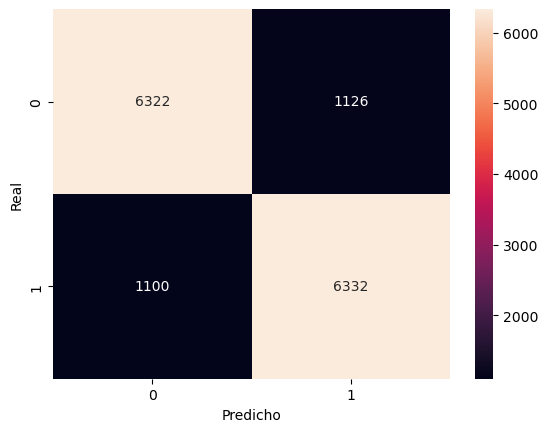

In [88]:
prediccion_heatmap = np.where(prediccion == 'positivo', 1, 0)

tabla = confusion_matrix(y_test, prediccion_heatmap)
sns.heatmap(tabla, annot=True, fmt='d')
plt.xlabel('Predicho')
plt.ylabel('Real')
plt.show()

In [89]:
train_sequences = tok.texts_to_sequences(X_train)
train_sequences_matrix = pad_sequences(train_sequences, maxlen=max_len)
prediccion_train = model_rnn.predict(train_sequences_matrix)
prediccion_train = np.where(prediccion_train >= 0.5, 1, 0)
mostrar_scores(y_train, prediccion_train)

   1/1085 [..............................] - ETA: 4:56

2023-11-15 21:23:10.561498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-15 21:23:10.561955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-15 21:23:10.562568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1085/1085 [==============================] - 114s 105ms/step
Accuracy: 0.9131311385696592
Recall: 0.9119399564569726
Precision: 0.9149804552770752
f1 score: 0.9134576757532281


In [92]:
np.random.seed(1)
tf.random.set_seed(1)
keras.utils.set_random_seed(812)
os.environ['PYTHONHASHSEED']=str(1)

df_preprocesado_copy = df_preprocesado.copy()
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})
x_train, x_test, y_train, y_test = train_test_split(df_preprocesado_copy['review_es'], df_preprocesado_copy['sentimiento'], test_size=0.3, random_state=42)

max_len = 1000
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = pad_sequences(sequences,maxlen=max_len)

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=128),
    tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x=sequences_matrix, y=y_train, epochs=10)

# model.evaluate(x=x_test, y=y_test)


Epoch 1/10


2023-11-15 22:15:33.883538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-15 22:15:33.884783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-15 22:15:33.885307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1085/1085 [==============================] - 553s 509ms/step - loss: 0.4476 - accuracy: 0.7848
Epoch 2/10
1085/1085 [==============================] - 536s 494ms/step - loss: 0.2515 - accuracy: 0.8988
Epoch 3/10
1085/1085 [==============================] - 531s 489ms/step - loss: 0.1804 - accuracy: 0.9318
Epoch 4/10
1085/1085 [==============================] - 533s 491ms/step - loss: 0.1094 - accuracy: 0.9612
Epoch 5/10
1085/1085 [==============================] - 539s 497ms/step - loss: 0.0599 - accuracy: 0.9803
Epoch 6/10
1085/1085 [==============================] - 553s 509ms/step - loss: 0.0414 - accuracy: 0.9860
Epoch 7/10
1085/1085 [==============================] - 540s 498ms/step - loss: 0.0246 - accuracy: 0.9921
Epoch 8/10
1085/1085 [==============================] - 539s 497ms/step - loss: 0.0200 - accuracy: 0.9933
Epoch 9/10
1085/1085 [==============================] - 536s 494ms/step - loss: 0.0201 - accuracy: 0.9929
Epoch 10/10
1085/1085 [==============================] - 

In [95]:
test_sequences = tok.texts_to_sequences(x_test)
test_sequences_matrix = pad_sequences(test_sequences, maxlen=1000)
prediccion = model.predict(test_sequences_matrix)
prediccion = np.where(prediccion >= 0.5, 1, 0)
mostrar_scores(y_test, prediccion)
prediccion = np.where(prediccion == 1, 'positivo', 'negativo')

465/465 [==============================] - 53s 113ms/step
Accuracy: 0.8436155913978495
Recall: 0.8690796555435952
Precision: 0.8266990912581594
f1 score: 0.8473597900951131


In [97]:
train_sequences = tok.texts_to_sequences(x_train)
train_sequences_matrix = pad_sequences(train_sequences, maxlen=max_len)
prediccion_train = model.predict(train_sequences_matrix)
prediccion_train = np.where(prediccion_train >= 0.5, 1, 0)
mostrar_scores(y_train, prediccion_train)

2023-11-15 23:53:15.747490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-11-15 23:53:15.748132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-11-15 23:53:15.748825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1085/1085 [==============================] - 126s 115ms/step
Accuracy: 0.9976669834960684
Recall: 0.999427065429128
Precision: 0.9959463317156723
f1 score: 0.997683662672653


### SVM

In [100]:
from sklearn.discriminant_analysis import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

df_preprocesado_copy = df_preprocesado.copy()
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})
X_train, X_test, y_train, y_test = train_test_split(df_preprocesado_copy['review_es'], df_preprocesado_copy['sentimiento'], test_size=0.3, random_state=42)

modelo_svm = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=14500)), 
    ('svm', SVC(C=0.1, random_state=42, gamma='auto', kernel='poly', degree=3))
    ])

modelo_svm.fit(X_train, y_train)

y_pred = modelo_svm.predict(X_test)
f1 = f1_score(y_test, y_pred)
print(f'F1_score: {f1}')
f1_train = f1_score(y_train, modelo_svm.predict(X_train))
print(f'F1_score train: {f1_train}')

F1_score: 0.6661885980638221
F1_score train: 0.6690817089299063


### Ensamble de modelos

In [48]:
display(df_preprocesado_copy)

,ID,review_es,sentimiento
0,0,críticos mencionado después ver solo oz episod...,1
1,1,pequeña pequeña producciónla técnica filmación...,1
2,2,pensé manera maravillosa pasar tiempo fin sema...,1
3,3,básicamente familia niño pequeño jake piensa z...,0
4,4,amor tiempo petter mattei película visualmente...,1
...,...,...,...
49995,49995,pensé película hizo buen trabajo derechano tan...,1
49996,49996,mala parcela mal diálogo mala actuación direcc...,0
49997,49997,católica enseñada escuelas primarias parroquia...,0
49998,49998,voy tener desacuerdo comentario anterior lado ...,0


In [29]:
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

df_preprocesado_copy = df_preprocesado.copy()
df_preprocesado_copy['sentimiento'] = df_preprocesado_copy['sentimiento'].map({'negativo': 0, 'positivo': 1})
X_train, X_test, y_train, y_test = train_test_split(df_preprocesado_copy['review_es'], df_preprocesado_copy['sentimiento'], test_size=0.3, random_state=42)

estimators = [('xgb', modelo_xg_boost), ('lr', modelo_regresion_logistica), ('mnb', modelo_tfidf)]
ensamble = VotingClassifier(estimators=estimators, voting='soft')
ensamble.fit(X_train, y_train)

prediccion = ensamble.predict(X_test)
mostrar_scores(y_test, prediccion)

Accuracy: 0.874260752688172
Recall: 0.8969321851453176
Precision: 0.8578046583451293
f1 score: 0.8769321844372822


In [30]:
prediccion_train = ensamble.predict(X_train)

mostrar_scores(y_train, prediccion_train)

Accuracy: 0.9159538005126876
Recall: 0.9333677094075856
Precision: 0.902748531530533
f1 score: 0.9178028169014084


#### Prediccion en los datos de test

In [31]:
df_test = pd.read_csv('test.csv', sep=',')
df_test

,ID,review_es
0,60000,La mayor virtud de esta película es su existen...
1,60001,"No soy un experto cinéfilo, pero pocas veces m..."
2,60002,Si no eres un incondicional del humor estilo T...
3,60003,"No sé qué está pasando, si la gente se deja ll..."
4,60004,"Pero cuando amanece,y me quedo solo,siento en ..."
...,...,...
8594,68594,"Buena no, lo siguiente. Por fin un film serio ..."
8595,68595,"Me esperaba mucho, pero que mucho, más.Guión m..."
8596,68596,"De mal cuerpo como sensación al finalizar, de ..."
8597,68597,Los que han añadido comentarios os lo han dich...


In [34]:
df_test_copia = df_test.copy()
df_test_copia['review_es'] = df_test_copia['review_es'].apply(preprocess_text)

train_sequences = tok.texts_to_sequences(df_test_copia['review_es'])
train_sequences_matrix = pad_sequences(train_sequences, maxlen=max_len)
prediccion_final = model.predict(train_sequences_matrix)
prediccion_final = np.where(prediccion_final >= 0.5, 1, 0)


prediccion_final = np.where(prediccion_final == 0, 'negativo', 'positivo')


df_entrega = df_test.copy()

df_entrega['sentimiento'] = prediccion_final
df_entrega.drop('review_es', axis=1, inplace=True)

df_entrega.to_csv('rnr_conv.csv', index=False)

### Red Neuronal Recurrente

In [ ]:
df_copia = df.copy()
X_train, X_test, y_train, y_test = train_test_split(df_preprocesado_copy['review_es'], df_preprocesado_copy['sentimiento'], test_size=0.3, random_state=42)
x_train, x_test, y_train, y_test = train_test_split(df_copia['review_es'], df_copia['sentimiento'], test_size=0.3, random_state=42)
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=10000, lower = True)
tokenizer.fit_on_texts(x_train)

vocabulario = tokenizer.word_index+1

